# Webscraping and analyzing reviews on comics for readcomiconline.to

In [6]:
# GENERAL
import re
import json
import numpy as np
import pandas as pd

# WEBSCRAPING
import requests
import bs4 as bs

# SELENIUM
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait

# NLP
import spacy
from textblob import TextBlob
from collections import Counter
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# GRAPHICS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 0. Webscrape results, export to dataframe

## 0.0 Functions

In [7]:
def harvest(urls, df=None, outfile="comic_comments/comic_comments.csv"):
    """
    Takes a list of urls of comic series and a df (optional)
    Scrapes and runs NLP for every comic series url in the list.
    Scrapes comments, populates tables and exports CSVs for every issue in the series.
    Returns df of all comics/comments
    """
    # INITIATE DF IF NOT PASSED IN
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print(f"df loaded. df length: {len(df)}")

    # CALLS SCRAPE_SERIES FOR EACH SERIES, UPDATES df
    for series_homepage in urls:
        df = scrape_series(series_homepage=series_homepage, outfile=outfile, df=df)
        
    return df

In [15]:
# SCRAPE COMIC SERIES URL - GET ALL ISSUES URL
def get_issues(series_homepage):
    """
    Takes in a url for a comic series
    Returns a list of every comic's link in the series
    """
    
    # INSTANTATE SELENIUM WEBDRIVER
    driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')
#     driver = webdriver.Chrome(executable_path='webdriver/chromedriver')

    # LOAD COMIC SERIES PAGE TO SCRAPE
    driver.get(series_homepage)
    driver.implicitly_wait(15) # Wait to load
    
    driver.implicitly_wait(60) # Extra wait time (for CAPTCHA)
    
    # GET LIST OF issue_urls
    issue_table = driver.find_element_by_class_name("listing")
    all_issues = issue_table.find_elements_by_tag_name("a")
    issue_urls = [issue.get_attribute("href") for issue in all_issues]
    print(f"Get Issues: total issues found: {len(issue_urls)}")
    driver.close() # close webpage
    return(issue_urls)

In [27]:
def scrape_series(series_homepage, outfile="comic_comments/comic_comments.csv", df=None, prev_fails=0):
    """
    Takes in a comic series homepage (e.g. https://readcomiconline.to/Comic/The-Wild-Storm/)
    Can be passed a df with some issues already scraped (df=None)
    Can set the outfile (outfile="comic_comments/comic_comments.csv")
    Saves running df of scraped comments to outfile
    Returns a df populated with comments for all scraped issues for the series
    """
    print(f"Scrape_series initaiated for {series_homepage}")
    fails = 0
    max_fails = 8
    issues_scraped = 0
    
    # INITIATE DF IF NOT PASSED IN
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print(f"df loaded. df length: {len(df)}")

    # GET ALL ISSUE URLS FOR A SERIES
    issue_urls = get_issues(series_homepage)
    print(f"Scrape_series: {len(issue_urls)} issues found for {series_homepage}")
    
    # FOR EVERY ISSUE IN THE SERIES...
    for issue_url in issue_urls:
        if fails >= max_fails: # MAX FAILS CONDITION (CAPTCHA NEEDS TO BE TOLD YOU'RE A HUMAN)
            print("Max fails reached. Breaking")
            break
        else:
            # REMOVE UNNECESSARY PARAMETERS FROM issue_name (IF PRESENT)
            if "?" in issue_url:
                issue_url = issue_url[:issue_url.find('?id')]

            issue_name = issue_url[33:]

            # ... IF THE ISSUE HAS NOT BEEN SCRAPED YET...
            if issue_name not in df['Webpage'].values:
                print(f"Now scraping: {issue_url}")

                # ... RUN ALL WEBSCRAPING FUNCTIONS
                try:
                    soup = get_comment_soup(issue_url)
                    json_data = soup_to_json(soup)
                    df = get_messages(df, issue_name, json_data)
                    df.to_csv(outfile) # SAVE AFTER EVERY SUCCESSFUL ISSUE SCRAPE
                    issues_scraped = issues_scraped + 1
                    print(f"Total issues scraped: {issues_scraped}")
                        
                # IF WEBSCRAPING FAILS
                except:
                    fails = fails + 1
                    print(f"SCRAPING FAILED for {issue_url} - total fails: {fails}")
                    
                    continue
            else:
                print(f"{issue_name} already scraped.")
                
    # IF ANY ISSUE FAILED TO SCRAPE...
    print(f"Scraped {series_homepage} with {fails} fails.")
    if fails > 0 and fails < max_fails:
        if fails != prev_fails: # ...IF FAILS NOT SAME AS BEFORE, RUNS FUNCTION RECURSIVELY
            df = scrape_series(series_homepage=series_homepage, df=df, prev_fails=fails)
        else:
            print(f"TOTAL SCRAPE FAILS: {fails}")
    
    return df

In [28]:
def get_comment_soup(issue_url):
    """
    For a given url, driver, uses Selenium to get the "src" link to the Disqus comments page.
    Returns bs4 soup file for Disqus comments page.
    """
    
    # INSTANTATE SELENIUM WEBDRIVER
    driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')
#     driver = webdriver.Chrome(executable_path='webdriver/chromedriver')
    
    driver.implicitly_wait(60) # Wait 1 minute to reduce CAPTCHA issues
    
    driver.get(issue_url)
    driver.implicitly_wait(15) # Wait to load
    
#     frame = driver.find_elements_by_id("disqus_thread")
#     print("Disqus Threads elements:",len(frame))
    
    iframe = driver.find_elements_by_css_selector("[title='Disqus']")

    iframe_url = iframe[1].get_attribute('src') # "src" is link to Disqus comments
#     print(iframe_url)
    driver.close() # close webpage

    # Instantiate BS, create soup for Disqus url
    source_code = requests.get(iframe_url)
    plain_text = source_code.text
    soup = bs.BeautifulSoup(plain_text, 'html.parser')
    return soup

In [29]:
def soup_to_json(soup):
    """
    Returns json-formatted messages of bs4 soup file
    Returns json_data, a list of dicts
    """
    json_data_str = str(soup.find("script", {"id" : "disqus-threadData"})) # string of json_data
    json_data_str2 = json_data_str[json_data_str.find('json')+6:-9] # remove head/foot tags
    json_data = json.loads(json_data_str2) # string to json
    json_data = json_data['response']['posts']
    
    return json_data

In [32]:
def get_messages(df, issue_name, json_data):
    """
    Takes in a df of form ['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports']
    Appends each message and metadata (50 max) to that df.
    Returns the updated df
    """        
    
    # IF THERE ARE NO COMMENTS
    if len(json_data) == 0:
        message = "NO_COMMENTS"
        author, likes, dislikes, numReports = 0,0,0,0
        print(f"No comments for issue {issue_name}")
    
    # IF THERE ANY COMMENTS (50 MAX PER ISSUE)
    else: 
        for i in range(len(json_data)):
            message = json_data[i]['message'] # MESSAGE
            message = re.compile(r'<[^>]+>').sub('', message) # remove all html tags
            try:
                author = json_data[i]['author']['username'] # if the author has a username
            except:
                author = json_data[i]['author']['name'] # if the author is a guest
            likes = json_data[i]['likes']
            dislikes = json_data[i]['dislikes']
            numReports = json_data[i]['numReports']

    # APPEND LINE TO DF
    data=[issue_name, message, author, likes, dislikes, numReports]
    append_me = pd.Series(data=data, index = df.columns)
    df = df.append(append_me, ignore_index=True) # Append the new Series into df
        
    return df

In [31]:
# NOT PART OF WEBSCRAPING PIPELINE
def scrape_single_issue(url, df=None):
    """
    Scrapes issue for a single url (e.g. "https://readcomiconline.to/Comic/The-Wild-Storm/Issue-4")
    Can be passed a df with some issues already scraped
    Returns a df with comments for single scraped issue
    """
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print("df loaded")

#     driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')
#     driver = webdriver.Chrome(executable_path='/Users/ari/Documents/Data Science Projects/Comic Comments NLP/webdriver/chromedriver')

    if url[33:] not in df['Webpage'].values: # If the webpage hasn't yet been scraped
        # RUN ALL FUNCTIONS
        try:
            print(f"Now scraping: {url[33:]}")
            soup = get_comment_soup(url)
            json_data = soup_to_json(soup)
            df = get_messages(df, url, json_data)
            df.to_csv('comic_comments/comic_comments.csv') # SAVE AFTER EVERY SUCCESSFUL ISSUE SCRAPE
        # IF WEBSCRAPING FAILS
        except:
            print(f"SCRAPING FAILED for {url}")
    driver.close()
            
    return df

## 0.1 Webscrape comments for one issue

In [27]:
# SAMPLE SINGLE-ISSUE SCRAPING
url = "https://readcomiconline.to/Comic/The-Wild-Storm/Issue-4"
df_wild_issue = scrape_single_issue(url)
df_wild_issue

new df created
Now scraping: The-Wild-Storm/Issue-4
Disqus Threads elements: 1
Num iframes:  3
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }


NameError: name 'driver' is not defined

## 0.2 Webscrape comic series

In [36]:
# SAMPLE SERIES SCRAPING (3 SHORT SERIES)
series_urls = ["https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles",\
              "https://readcomiconline.to/Comic/The-Lone-Ranger-2018",\
              "https://readcomiconline.to/Comic/Wonder-Twins"]
df = harvest(series_urls)

new df created
Attempting to scrape https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles
df loaded. df length: 0
Now scraping: https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles/Issue-6
Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
           

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Now scraping: https://readcomiconline.to/Comic/The-Lone-Ranger-2018/Issue-5
Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
   

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Attempting to scrape https://readcomiconline.to/Comic/Wonder-Twins
df loaded. df length: 47
Now scraping: https://readcomiconline.to/Comic/Wonder-Twins/Issue-4
Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--wa

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

## 0.3 Webscrape most popular comic series

In [35]:
# GET A LIST OF THE MOST POPULAR SERIES
url = "https://readcomiconline.to/ComicList/MostPopular"

popular_series = get_issues(url)
popular_series = [series for series in popular_series if "?" not in series]
print(popular_series)

Get Issues: total issues found: 71
['https://readcomiconline.to/Comic/The-Walking-Dead', 'https://readcomiconline.to/Comic/Injustice-2', 'https://readcomiconline.to/Comic/Batman-2016', 'https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963', 'https://readcomiconline.to/Comic/Ultimate-Spider-Man-2000', 'https://readcomiconline.to/Comic/Saga', 'https://readcomiconline.to/Comic/The-Flash-2016', 'https://readcomiconline.to/Comic/Invincible', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Five', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-I', 'https://readcomiconline.to/Comic/Darth-Vader-2017', 'https://readcomiconline.to/Comic/Detective-Comics-2016', 'https://readcomiconline.to/Comic/W-i-t-c-h', 'https://readcomiconline.to/Comic/Rick-and-Morty', 'https://readcomiconline.to/Comic/Uncanny-X-Men-1963', 'https://readcomiconline.to/Comic/Sonic-The-Hedgehog', 'https://readcomiconline.to/Comic/Fables', 'https://readcomiconline.to/Comic/Red-Hood-and-the-Outlaws

In [36]:
# MOST RECENT POPULAR_SERIES
popular_series = ['https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963', 'https://readcomiconline.to/Comic/Ultimate-Spider-Man-2000', 'https://readcomiconline.to/Comic/Saga', 'https://readcomiconline.to/Comic/The-Flash-2016', 'https://readcomiconline.to/Comic/Invincible', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Five', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-I', 'https://readcomiconline.to/Comic/Darth-Vader-2017', 'https://readcomiconline.to/Comic/Detective-Comics-2016', 'https://readcomiconline.to/Comic/W-i-t-c-h', 'https://readcomiconline.to/Comic/Rick-and-Morty', 'https://readcomiconline.to/Comic/Uncanny-X-Men-1963', 'https://readcomiconline.to/Comic/Sonic-The-Hedgehog', 'https://readcomiconline.to/Comic/Fables', 'https://readcomiconline.to/Comic/Red-Hood-and-the-Outlaws-2016', 'https://readcomiconline.to/Comic/Nightwing-2016', 'https://readcomiconline.to/Comic/Superman-2016', 'https://readcomiconline.to/Comic/Teen-Titans-2016', 'https://readcomiconline.to/Comic/Crossed-Badlands', 'https://readcomiconline.to/Comic/Justice-League', 'https://readcomiconline.to/Comic/Justice-League-2016', 'https://readcomiconline.to/Comic/Spawn', 'https://readcomiconline.to/Comic/Spider-Man-Deadpool', 'https://readcomiconline.to/Comic/The-Amazing-Spider-Man-2015', 'https://readcomiconline.to/Comic/Action-Comics-2016', 'https://readcomiconline.to/Comic/Old-Man-Logan-2016', 'https://readcomiconline.to/Comic/Titans-2016', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Two', 'https://readcomiconline.to/Comic/Preacher', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Three', 'https://readcomiconline.to/Comic/The-Boys', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Four', 'https://readcomiconline.to/Comic/Batman-1940', 'https://readcomiconline.to/Comic/Dark-Nights-Metal', 'https://readcomiconline.to/Comic/Mighty-Morphin-Power-Rangers', 'https://readcomiconline.to/Comic/Star-Wars-2015', 'https://readcomiconline.to/Comic/Injustice-Ground-Zero', 'https://readcomiconline.to/Comic/The-Sandman-1989', 'https://readcomiconline.to/Comic/Wonder-Woman-2016', 'https://readcomiconline.to/Comic/Doomsday-Clock', 'https://readcomiconline.to/Comic/Deadpool-2016', 'https://readcomiconline.to/Comic/Batman-2011', 'https://readcomiconline.to/Comic/The-Amazing-Spider-Man-2018', 'https://readcomiconline.to/Comic/Super-Sons', 'https://readcomiconline.to/Comic/Hal-Jordan-And-The-Green-Lantern-Corps', 'https://readcomiconline.to/Comic/Spider-Man-2016', 'https://readcomiconline.to/Comic/Darth-Vader']
current_series = ['https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963']

In [37]:
# LOAD A CSV FILE TO A DF (IF NEEDED)
csv_file_path = "comic_comments/comic_comments.csv"
loaded_df = pd.read_csv(csv_file_path, index_col='Unnamed: 0', encoding = "ISO-8859-1")
len(loaded_df)

3485

In [38]:
# SCRAPE ALL ISSUES FOR EVERY SERIES IN popular_series - takes in a loaded_df
# df = harvest(popular_series, df=loaded_df)

# SCRAPE INDIVIDUAL SERIES
df = harvest(current_series, df=loaded_df)

df loaded. df length: 3485
Scrape_series initaiated for https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963
df loaded. df length: 3485


KeyboardInterrupt: 

# 1. NLP: Sentiment Analysis on Comments

Let's use both Textblob, Vader to analyze the sentiment of each comment.

In [39]:
# LOAD NLP MODEL
nlp = spacy.load('en_core_web_lg')

## 1.0 Functions

In [40]:
def add_nlp_columns(df):
    """
    Updates df - adds NLP columns if it doesn't already have them
    Returns None
    """

    if "Compound" not in df.columns: # CHECK IF COLUMNS ALREADY EXIST
    
        # ADD NLP COLUMNS
        df['Polarity'] = None
        df['Subjectivity'] = None
        df['Positive'] = None
        df['Negative'] = None
        df['Neutral'] = None
        df['Compound'] = None

    return None

In [42]:
def sentiment_analysis(csv_file_path="comic_comments/comic_comments.csv"):
    """
    Takes in a webscraped csv of comments (comments in "Message" column)
    Returns an updated df with TextBlob and Vader columns for each comment
    Writes the updated df to file
    """
    # LOAD COMMENTS DF
    df = pd.read_csv(csv_file_path, index_col='Unnamed: 0', encoding = "ISO-8859-1")
    
    # ADD SENTIMENT COLUMNS
    add_nlp_columns(df)
    
    # Instantiate Vader analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # DROP NaNs (blank/deleted comments )
    df.dropna(subset=['Message'], inplace=True)
    
    # FILL IN TextBlob COLUMNS,
    pol = lambda x: round(TextBlob(x).sentiment.polarity,3)
    sub = lambda x: round(TextBlob(x).sentiment.subjectivity,3)
    
    df['Polarity'] = df['Message'].apply(pol)
    df['Subjectivity'] = df['Message'].apply(sub)

    # FILL IN Vader COLUMNS
    pos = lambda x: round(analyzer.polarity_scores(x)['pos'],3)
    neg = lambda x: round(analyzer.polarity_scores(x)['neg'],3)
    neu = lambda x: round(analyzer.polarity_scores(x)['neu'],3)
    compound = lambda x: round(analyzer.polarity_scores(x)['compound'],3)

    df['Positive'] = df['Message'].apply(pos)
    df['Negative'] = df['Message'].apply(neg)    
    df['Neutral'] = df['Message'].apply(neu)
    df['Compound'] = df['Message'].apply(compound)

    
    # WRITE TO FILE
    df.to_csv(csv_file_path)
    print(f"Successfully performed sentiment analysis on {csv_file_path}")
    return df

## 1.1 Sample sentiment analysis

Let's apply sentiment scores to comments for a scraped comic series

In [43]:
# CREATE AND FILL IN SENTIMENT COLUMNS
df_comments = sentiment_analysis(csv_file_path)

Successfully performed sentiment analysis on comic_comments/comic_comments.csv


Now let's visually analyze the results:

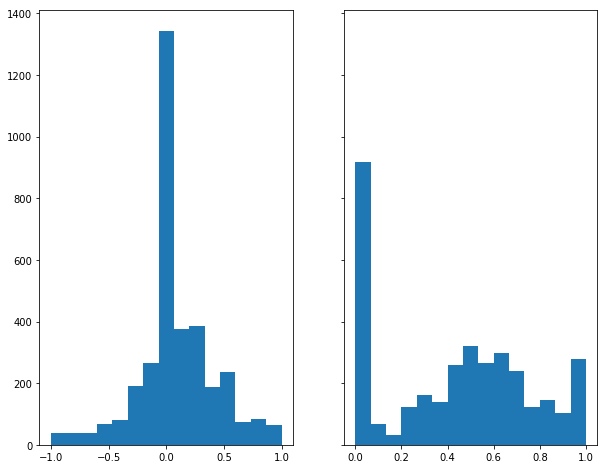

In [44]:
# PLOT RESULTS (TextBlob) - HISTOGRAMS
x = df_comments['Polarity'].values
y = df_comments['Subjectivity'].values

# plt.rcParams['figure.figsize']=[12,10]
# plt.subplot(1,2,1)
# plt

f, ax = plt.subplots(1,2, figsize=(10,8), sharey=True)
ax[0].hist(x, bins=15)
ax[1].hist(y, bins=15)
plt.show();

## IMPROVE SUBPLOTS

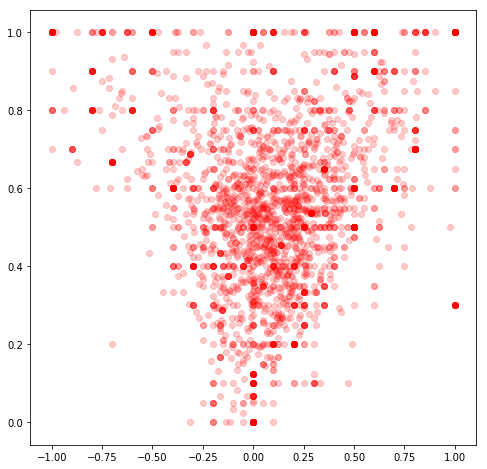

In [45]:
# PLOT RESULTS (TextBlob) - SCATTERPLOT, subjectivity vs. polarity
plt.figure(figsize=(8,8))
plt.scatter(x, y, marker='o', color = 'red', alpha=0.2)
plt.show();

# 2. Set up, run webscraping pipeline

In [52]:
df_comments.sort_values(by="Likes", ascending=False)

,Webpage,Message,Author,Likes,Dislikes,NumReports,Polarity,Subjectivity,Positive,Negative,Neutral,Compound
0,The-Amazing-Spider-Man-1963/Issue-800,Althought I'm not a big fan of Dan Slott's wri...,architectofcomics,57,0,0,0.255,0.600,0.169,0.128,0.702,0.684
655,The-Amazing-Spider-Man-1963/Issue-789,I am tried of peter being treated like a compl...,tevyasmolka,49,1,0,-0.033,0.800,0.150,0.192,0.659,-0.178
508,The-Amazing-Spider-Man-1963/Issue-797,"Okay this was pretty good and nice going JJ, y...",kuroookami,44,0,0,0.155,0.491,0.174,0.027,0.799,0.904
50,The-Amazing-Spider-Man-1963/Issue-799,Well... shit.,knightmysterio,42,0,0,-0.200,0.800,0.000,0.783,0.217,-0.557
509,The-Amazing-Spider-Man-1963/Issue-797,Marvel's Rule 101 for Peter Parker/Spider-man ...,jasonm86,34,1,0,-0.050,0.850,0.247,0.168,0.585,0.457
458,The-Amazing-Spider-Man-1963/Issue-801,Glad to see Slott gets Spider-Man's character ...,disqus_Ei9DU60Qsk,32,1,0,0.500,1.000,0.214,0.000,0.786,0.459
605,The-Amazing-Spider-Man-1963/Issue-792,They FINALLY made the Web of Shadows game into...,Superboy8338,30,0,0,0.025,0.725,0.101,0.000,0.899,0.226
660,The-Amazing-Spider-Man-1963/Issue-789,I felt bad for Peter in this issue because no ...,disqus_bvaJgFELO7,28,0,0,-0.011,0.719,0.120,0.159,0.721,-0.793
558,The-Amazing-Spider-Man-1963/Issue-793,So happy Joe Robertson actually has a brain. I...,kuroookami,28,0,0,0.257,0.407,0.224,0.110,0.666,0.531
54,The-Amazing-Spider-Man-1963/Issue-799,Holy shit! Red Goblin has just obliterated eve...,architectofcomics,27,0,0,0.033,0.483,0.112,0.325,0.563,-0.878


# 2. Comic Reviews EDA

## 2.1 Most common review words

USE PREVIOUS NLP SpaCy notebook TO DETERMINE MOST COMMON WORDS

GENERATE A TF-IDF OR WORD COUNT DF

VISUALIZE BY USING WORDCLOUD

https://www.youtube.com/watch?v=VraAbgAoYSk

In [18]:
temp = pd.read_csv('comic_comments/batman_2016_comments.csv')

In [ ]:
# PLOT SENTIMENTS